In [1]:
## Bring in needed mod, pandas
import pandas as pd, numpy as np, glob
from matplotlib import pyplot as plt
%matplotlib inline

## Write ftn for median filtering
def median_filter(Y,Kernal,padtype=None,recursive=False):
    window = int((Kernal-1)/2)
    Y = np.array(Y)
    assert len(Y[~np.isnan(Y)]) == len(Y)
    if padtype is None:
        rb = np.ones(window)*Y[0]
        re = np.ones(window)*Y[-1]
    elif padtype is 'Zero':
        rb = np.zeros(window)
        re = np.zeros(window)
    elif padtype is 'Ref':
        rb = list(Y[0] - Y[::-1] + Y[0])[-(window+1):-1]
        re = list(Y[-1] - Y[::-1] + Y[-1])[1:(window+1)]
    else:
        rb = np.zeros(window)
        re = np.ones(window)*Y[-1]
    pry = np.concatenate([rb,Y,re])
    if recursive:
        for i in np.arange(window,len(pry)-window):
            pry[i] = np.median(pry[i-window:i+window+1])
        my = pry[window:-window]
    else:
        my = np.array([np.median(pry[i-window:i+window+1]) for i in np.arange(window,len(pry)-window)])
    return my

## Set kerneal zise to 10 time points (1.5 hrs), around a given pt
ks = 51

In [2]:
## Bring in data
file_path = '../DATA/PHENOTYPE/GROWTHCURVES/Tecan-deletion-plate-July252019_baselined.csv.gz'
df = pd.read_csv(file_path,index_col=0)
df.head()

,date,plate,rep,row,column,chr,type,strain,background,gene,...,251100s,252000s,252900s,253800s,254700s,255600s,256500s,257400s,258300s,259200s
13,Apr252019,2,2,b,2,2.0,knockout,CNB02995,KN99 alpha,NaN,...,0.5318,0.5308,0.5308,0.5308,0.5308,0.5318,0.5318,0.5308,0.5318,0.5318
14,Apr252019,2,2,b,3,2.0,knockout,CNB03020,CM018,IRK5,...,0.7998,0.7998,0.7998,0.7988,0.7988,0.7988,0.7998,0.7988,0.7988,0.7978
15,Apr252019,2,2,b,4,2.0,knockout,CNB03090,KN99 alpha,SSK1,...,0.4740,0.4730,0.4730,0.4730,0.4730,0.4730,0.4730,0.4720,0.4720,0.4720
16,Apr252019,2,2,b,5,2.0,knockout,CNB03170,KN99 alpha,NaN,...,0.5198,0.5198,0.5198,0.5198,0.5188,0.5188,0.5188,0.5188,0.5188,0.5178
17,Apr252019,2,2,b,6,2.0,knockout,CNB03200,KN99 alpha,NaN,...,0.5244,0.5244,0.5244,0.5244,0.5234,0.5234,0.5234,0.5234,0.5234,0.5234


In [3]:
## Take column names
dfcols = df.columns.tolist()
## Get time start index
timeix = dfcols.index('0s')
## Get time columns
timepts = dfcols[timeix:]
## Get info columns
infos = dfcols[:timeix]
## Check baselining
assert df[timepts[:7]].sum(axis=1).sum() == 0

In [4]:
## Median filter the data via the awesome ftn I wrote above! 
mdf = df[timepts].T.apply(median_filter,args=[ks]).T

In [5]:
## add info dataframe
mdfi = pd.concat([df[infos],mdf],axis=1)

In [6]:
## Save dataframe
mdfi.to_csv(file_path.split('.csv')[0]+'_median%s.csv'%(ks))

In [7]:
SSK1 = [a for a in mdfi[(mdfi.gene=='SSK1') & 
                (mdfi.type=='knockout')].groupby(['temp','amphB'])]

In [8]:
timex = np.array([float(a[:-1])/(60**2) for a in timepts])

In [9]:
Units = [u'°C', '\u03BCg/ml']

In [10]:
mdfi['strain'].replace(dict(zip(['KN99 alpha'],
                                ['KN99\u03B1'])),
                       inplace=True)

In [11]:
ssk1 = mdfi[(mdfi.gene=='SSK1') & (mdfi.type=='knockout')]

In [12]:
ssk1_g = [a for a in ssk1.groupby(['temp','amphB'])]

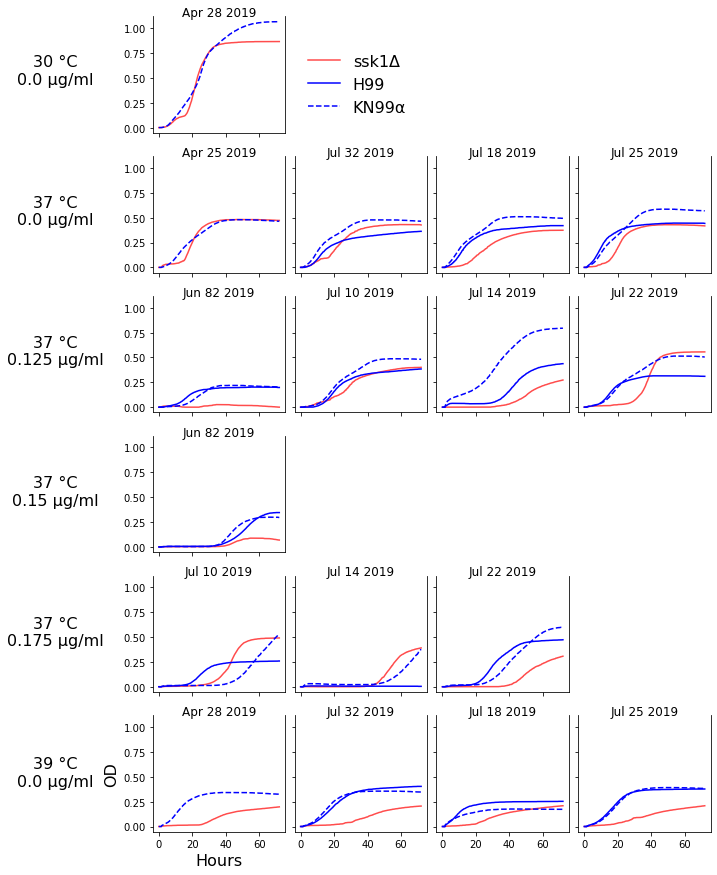

In [13]:
fig, ax = plt.subplots(6,4,figsize=(10,15),sharey=True,sharex=True)

for c, g in enumerate(ssk1_g):
    axl = list(np.arange(4))
    fig.text(-0.01,.83 - (c*.13),'\n'.join([str(a)+' '+Units[z] for z,a in enumerate(g[0])]),
             fontsize=16,va='center',ha='center')
    for i,(l,j) in enumerate(g[1].iterrows()):
        plt.sca(ax[c,i])
        wt = mdfi[(mdfi.date==j.date) & 
              (mdfi.type=='wildtype') & 
              (mdfi.strain.isin(['H99','KN99α'])) & 
              (mdfi.temp==j.temp) & (mdfi.amphB==j.amphB)]
        plt.title('%s %s %s'%(j.date[:3],j.date[3:5],j.date[-4:]),
                  fontsize=12,y=.95)
        ax[c,i].spines['top'].set_visible(False)
        plt.plot(timex,j[timepts].values,color='r',
                 alpha=0.7,label='ssk1\u0394' if c*i == 1 else None);
        for t, k in wt.iterrows():
            plt.plot(timex,k[timepts].values,color='b',
            linestyle='-' if k.strain == 'H99' else '--',
                     label=k.strain if c*i == 1 else None)
        axl.remove(i)
    if len(axl)>0:
        for i in axl:
            plt.sca(ax[c,i])
            plt.axis('off')
plt.sca(ax[-1,0]);plt.xlabel('Hours',fontsize=16);plt.ylabel('OD',fontsize=16);
plt.subplots_adjust(wspace=0.07);
plt.sca(ax[1,1]);plt.legend(bbox_to_anchor=(0.95,2),frameon=False,fontsize=16);

In [14]:
dt = np.unique(np.diff(timex))[0]

In [15]:
htg_drug = mdfi[(mdfi.amphB==0.125) & 
                (mdfi.temp==37) & 
                (mdfi.strain.isin(['H99','KN99α','CNB03090']))].copy()

In [16]:
#contam_ix = mdfi[(mdfi.date=='Jul102019') & (mdfi.temp==37) & 
#     (mdfi.amphB==0.175) &  (mdfi.strain.isin(['H99','KN99α','CNB03090']))].index.tolist()
contam_ix = mdfi[(mdfi.date=='Jul102019') & 
                 (mdfi.strain.isin(
                     ['H99','KN99α','CNB03090']))].index.tolist()

In [17]:
txddf = mdfi[(mdfi.temp==37) & (mdfi.amphB.isin([0.0,0.125,0.175])) & 
                (mdfi.strain.isin(['KN99α','CNB03090']))].copy()

In [18]:
contam_ix_drop = [a for a in contam_ix if a in txddf.index]

In [19]:
txddf.drop(contam_ix_drop,axis=0,inplace=True)

In [20]:
txddf['AUC'] = txddf[timepts].sum(axis=1)*dt

In [21]:
txddfa = txddf[['strain','AUC','temp','amphB','date']].copy()

In [22]:
txddfa['strain'].replace(dict(zip(['CNB03090'],
            [r'$\it{ssk1}$'+'\u0394'])),inplace=True)

In [23]:
txddfa

,strain,AUC,temp,amphB,date
15,$\it{ssk1}$Δ,25.02850,37,0.000,Apr252019
63,KN99α,25.32287,37,0.000,Apr252019
303,$\it{ssk1}$Δ,0.85050,37,0.125,Jun82019
351,KN99α,10.47715,37,0.125,Jun82019
495,$\it{ssk1}$Δ,21.21595,37,0.000,Jul32019
543,KN99α,26.52420,37,0.000,Jul32019
879,$\it{ssk1}$Δ,5.59675,37,0.125,Jul142019
927,KN99α,33.12125,37,0.125,Jul142019
985,$\it{ssk1}$Δ,6.98270,37,0.175,Jul142019
989,KN99α,5.25840,37,0.175,Jul142019


In [24]:
mystrains = txddfa.strain.unique()[::-1]
mystrains

array(['KN99α', '$\\it{ssk1}$Δ'], dtype=object)

In [25]:
kn99_hd_ix = txddfa[(txddfa.temp==37) & 
                    (txddfa.amphB==0.125) & 
                    (txddfa.strain==mystrains[0])
                   ].index.tolist()

ssk1d_hd_ix = txddfa[(txddfa.temp==37) & 
                     (txddfa.amphB==0.125) & 
                     (txddfa.strain==mystrains[1])
                    ].index.tolist()

In [26]:
#https://www.ncbi.nlm.nih.gov/pmc/articles/PMC352226/

In [27]:
import seaborn as sns
import statsmodels.formula.api as smf

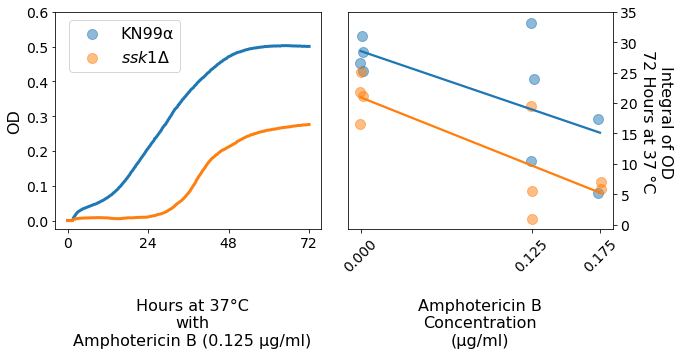

In [28]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
s0 ='OD'#'OD\n37 °C\n0.125 \u03BCg/ml'
s1 = u'Integral of OD\n72 Hours at 37 °C'
sx = 'Hours at 37°C\nwith\nAmphotericin B (0.125 \u03BCg/ml)'
plt.figtext(x=.96,y=0.5,s=s1,rotation=-90,fontsize=16,va='center',ha='center')

plt.sca(ax[0])
plt.ylabel(s0,fontsize=16)
plt.plot(timex,mdfi[timepts].T[kn99_hd_ix].T.mean(),color='tab:blue',linewidth=3);
plt.plot(timex,mdfi[timepts].T[ssk1d_hd_ix].T.mean(),color='tab:orange',linewidth=3);
plt.xticks([0,24,48,72],fontsize=14)
plt.xlabel(' ')
plt.figtext(0.715,-0.2,'Amphotericin B\nConcentration\n(\u03BCg/ml)',
            fontsize=16,va='center',ha='center')
plt.yticks(np.arange(0.0,0.65,.1),fontsize=14)

plt.sca(ax[1])
plt.ylabel(' ')
ax[1].yaxis.tick_right()

sns.regplot(x='amphB',y='AUC',
           data = txddfa[(txddfa.temp==37) & 
            (txddfa.strain == mystrains[0]) ],
            ci=False,label=mystrains[0],
           scatter_kws={'alpha':0.5,'s':100},x_jitter=0.002);
sns.regplot(x='amphB',y='AUC',
           data = txddfa[(txddfa.temp==37) & 
            (txddfa.strain == mystrains[1]) ],
            ci=False,label=mystrains[1],
           scatter_kws={'alpha':0.5,'s':100},x_jitter=0.002);
plt.legend(bbox_to_anchor=(-0.6,1),fontsize=16);
plt.xlabel('')
plt.figtext(0.315,-0.2,sx,
            fontsize=16,va='center',ha='center')

plt.xticks(txddfa.amphB.unique(),rotation=45,fontsize=14);
plt.yticks(np.arange(0,40,5),fontsize=14);
plt.ylabel(' ')

plt.subplots_adjust(wspace=0.1)
#plt.savefig('../SSK1_knockouts_regression.png',
#            dpi=150,bbox_inches='tight')

sns.lmplot(x='amphB',y='AUC',hue='strain',
           data = txddfa[(txddfa.temp==37)],hue_order=mystrains,ci=False,
           scatter_kws={'alpha':0.5,'s':100},legend=False,x_jitter=0.002);
plt.legend(bbox_to_anchor=(.55,.22),fontsize=16);
plt.xlabel('Amphotericin B \u03BCg/ml',fontsize=16)
plt.ylabel(u'Integral of OD\n72 Hours at 37 °C',fontsize=16)
plt.xticks(txddfa.amphB.unique(),rotation=45,fontsize=14);
plt.yticks(np.arange(0,40,5),fontsize=14);
plt.savefig('../SSK1_knockouts_regression.png',
            dpi=150,bbox_inches='tight')

In [29]:
mod = smf.ols(formula='AUC~strain+amphB', data= txddfa[(txddfa.temp==37)])
res = mod.fit()
res.summary()

/home/croth/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    AUC   R-squared:                       0.610
Model:                            OLS   Adj. R-squared:                  0.559
Method:                 Least Squares   F-statistic:                     11.75
Date:                Mon, 30 Nov 2020   Prob (F-statistic):           0.000849
Time:                        18:06:05   Log-Likelihood:                -57.875
No. Observations:                  18   AIC:                             121.8
Df Residuals:                      15   BIC:                             124.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          20.4237      2.773      7.365      0.000      14.513      26.334
strain[T.KN99α]     8.6513      3.113      2.779      0.014       2.017      15.286
amphB             -83.1879     20.939     -3.973      0.001    -127.818     -38.558
==============================================================================
Omnibus:                        1.418   Durbin-Watson:                   1.468
Prob(Omnibus):                  0.492   Jarque-Bera (JB):                0.625
Skew:                           0.456   Prob(JB):                        0.732
Kurtosis:                       3.049   Cond. No.                         15.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [30]:
mdfi.temp.unique()

array([37, 30, 39])

In [31]:
htg_knockouts = mdfi[(mdfi.temp.isin([37,39])) & 
                     (mdfi.chr==14) & 
                     (mdfi.amphB==0) & 
                     (mdfi.background!='CM018')]
htg_knockouts.shape

(78, 303)

In [32]:
htg_knockouts[['chr','type','strain','background']
             ].drop_duplicates().sort_values('strain')

,chr,type,strain,background
27,14.0,knockout,CNN01165,KN99 alpha
28,14.0,knockout,CNN01195,KN99 alpha
29,14.0,knockout,CNN01270,KN99 alpha
30,14.0,knockout,CNN01310,KN99 alpha
31,14.0,knockout,CNN01320,KN99 alpha
32,14.0,knockout,CNN01340,KN99 alpha
33,14.0,knockout,CNN01345,KN99 alpha
560,14.0,knockout,CNN01400,KN99 alpha
38,14.0,knockout,CNN01410,KN99 alpha
39,14.0,knockout,CNN01430,KN99 alpha


In [33]:
htg = mdfi[(mdfi.temp.isin([37,39])) & 
           (mdfi.chr==14) & 
           (mdfi.background=='KN99 alpha') & 
           (mdfi.amphB==0.0)]

In [34]:
mdfi[(mdfi.strain=='CNB03090')].head()

,date,plate,rep,row,column,chr,type,strain,background,gene,...,251100s,252000s,252900s,253800s,254700s,255600s,256500s,257400s,258300s,259200s
15,Apr252019,2,2,b,4,2.0,knockout,CNB03090,KN99 alpha,SSK1,...,0.4730,0.4730,0.4730,0.4730,0.4730,0.4730,0.4730,0.4720,0.4720,0.4720
111,Apr282019,2,2,b,4,2.0,knockout,CNB03090,KN99 alpha,SSK1,...,0.8652,0.8652,0.8652,0.8652,0.8652,0.8652,0.8652,0.8652,0.8652,0.8652
217,Apr282019,2,2,b,4,2.0,knockout,CNB03090,KN99 alpha,SSK1,...,0.1934,0.1934,0.1944,0.1944,0.1954,0.1954,0.1964,0.1964,0.1974,0.1974
303,Jun82019,3,3,b,4,2.0,knockout,CNB03090,KN99 alpha,SSK1,...,0.0026,0.0026,0.0016,0.0016,0.0016,0.0006,0.0006,0.0006,0.0000,0.0000
409,Jun82019,3,3,b,4,2.0,knockout,CNB03090,KN99 alpha,SSK1,...,0.0754,0.0744,0.0734,0.0724,0.0724,0.0714,0.0704,0.0704,0.0694,0.0694


In [35]:
mdfi[(mdfi.strain=='KN99α')].shape

(17, 303)

In [36]:
htg_H99 = mdfi[(mdfi.temp.isin([37,39])) & 
               (mdfi.strain.isin(['KN99α'])) & (mdfi.amphB==0.0)]
htg.shape

(78, 303)

In [37]:
htg_strains = sorted(htg.strain.unique())

KN99_names = ['CNAG_06389','CNAG_06394','CNAG_06401',
              'CNAG_06405','CNAG_06406',
              'CNAG_06408','CNAG_06409','CNAG_06415',
              'CNAG_06416','CNAG_06418']
Common_name = [np.nan,np.nan,'RIC8',np.nan,np.nan,
               np.nan,np.nan,'CCC2','DAP2',np.nan]

namedf = pd.DataFrame([htg_strains,KN99_names,Common_name],
                      index=['JEC21','H99','Common']).T
namedf.head()

,JEC21,H99,Common
0,CNN01165,CNAG_06389,NaN
1,CNN01195,CNAG_06394,NaN
2,CNN01270,CNAG_06401,RIC8
3,CNN01310,CNAG_06405,NaN
4,CNN01320,CNAG_06406,NaN


In [38]:
image_paths = sorted(glob.glob('../IMAGES/ldopa_crop_segs/knockouts/*.png'))
image_paths[:4]

['../IMAGES/ldopa_crop_segs/knockouts/B3_H99_WT.png',
 '../IMAGES/ldopa_crop_segs/knockouts/C10_CNN01345_CNAG_06409.png',
 '../IMAGES/ldopa_crop_segs/knockouts/C11_CNN01360_CNAG_06411.png',
 '../IMAGES/ldopa_crop_segs/knockouts/C4_CNN01165_CNAG_06389.png']

In [39]:
htgs = [a for a in htg.groupby('strain')]

In [40]:
from matplotlib import rc

In [41]:
from PIL import Image, ImageEnhance

In [42]:
htg_strains

['CNN01165',
 'CNN01195',
 'CNN01270',
 'CNN01310',
 'CNN01320',
 'CNN01340',
 'CNN01345',
 'CNN01400',
 'CNN01410',
 'CNN01430']

In [43]:
kn99_ric8 = pd.concat([htg[(htg.strain=='CNN01270')],htg_H99])
kn99_ric8.temp.unique()

array([37, 39])

In [44]:
kn99_ric8_out = '../DATA/PHENOTYPE/GROWTHCURVES/KN99_ric8_htg.csv.gz'
kn99_ric8.to_csv(kn99_ric8_out, index=False)

In [45]:
kn99 = 'CKF44'

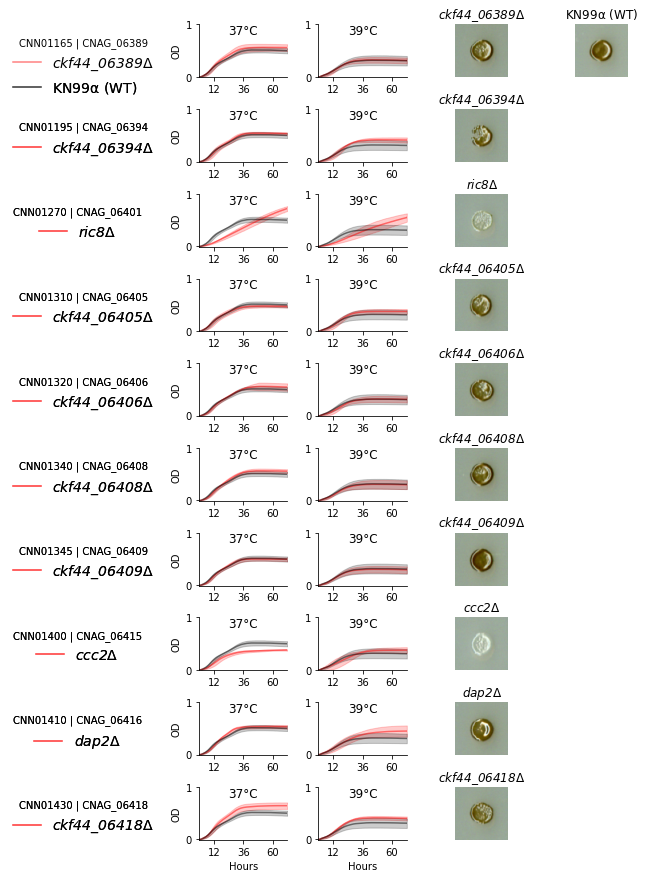

In [47]:
z = 1.96
fig,ax = plt.subplots(len(htg_strains),4,figsize=(8,15))
for i,(s,j) in enumerate(htgs):
    for c,k in enumerate([37,39]):
        plt.sca(ax[i,c])
        if c == 0:
            plt.ylabel('OD')
            sname = namedf[(namedf.JEC21==s)].dropna(axis=1).values[0]
            if (len(sname) > 2):
                wrname = r'%s / %s (%s)'%(sname[0],sname[1],sname[2])
            else:
                wrname = r'%s / %s'%(sname[0],sname[1])
        plt.ylim(-0.01,1);plt.xlim(0,72)
        
        
        N = htg_H99[(htg_H99.temp==k)& 
                        (htg_H99.strain=='KN99α')].shape[0]
        m = j[(j.temp==k)][timepts].mean().values
        mstd = j[(j.temp==k)][timepts].std(ddof=1).values
        
        
        cup = m + z*(mstd)/np.sqrt(N)
        clo = m - z*(mstd)/np.sqrt(N)
        
        if len(sname[-1].split('_'))<2:
            sn = sname[-1].lower()
        else:
            sn = kn99.lower()+'_'+sname[-1].split('_')[-1]
        
        l1, = plt.plot(timex,m,
                 'r-',alpha=0.5,label=u'%s$\u0394$'%(sn) 
                       if c == 0 else None)
        plt.fill_between(timex,y1=clo,y2=cup,alpha=0.2,color='r')
        
        N = htg_H99[(htg_H99.temp==k)& 
                        (htg_H99.strain=='KN99α')].shape[0]
        m = htg_H99[(htg_H99.temp==k)& 
                        (htg_H99.strain=='KN99α')][timepts].mean().values
        mstd = htg_H99[(htg_H99.temp==k)& 
                        (htg_H99.strain=='KN99α')][timepts].std(ddof=1).values
        
        cup = m + z*(mstd)/np.sqrt(N)
        clo = m - z*(mstd)/np.sqrt(N)
        
        l2, = plt.plot(timex,m,
                 'k-',alpha=0.5,label=r'KN99$\mathrm{\alpha}$ (WT)' 
                 if c == 0 and i == 0 else None)
        plt.fill_between(timex,y1=clo,y2=cup,alpha=0.2,color='k')
        
        plt.xticks([12,36,60])
        ax[i,c].spines['right'].set_visible(False)
        ax[i,c].spines['top'].set_visible(False)

        plt.title(u'%s\u00B0C'%(k),y=0.7,fontsize=12)
        if c == 0:
            az = plt.gca()
            l1_leg = az.legend(handles = [l1],loc='upper left',bbox_to_anchor=(-2.25,1),
                           fontsize=12,title='%s | %s'%(sname[0],sname[1]),
                            prop={'style':'italic','size':14},frameon=False)
            az.add_artist(l1_leg)
            if i == 0:
                l2_leg = az.legend(handles = [l2],loc='upper left',bbox_to_anchor=(-2.25,.2),
                           fontsize=12,prop={'size':14},frameon=False)
                az.add_artist(l2_leg)
            
            #print(sname[0])
            #image_path = '/home/croth/Downloads/knockout_melanin_cropped/%s.png'%(sname[0])
            image_path = glob.glob('../IMAGES/ldopa_crop_segs/knockouts/*%s*.png'%(sname[0]))[0]
            image_obj = Image.open(image_path)
            enhancer = ImageEnhance.Brightness(image_obj)
            temp = enhancer.enhance(1.52)
            plt.sca(ax[i,2])
            plt.imshow(temp)
            plt.axis('off')
            #plt.title(u'$\it{$%s$\u0394}$'%(sname[-1]))
            
                
            plt.title(u'%s$\u0394$'%(sn),fontstyle='oblique')
        
    
for i, j in enumerate(htg_strains):
    plt.sca(ax[i,2])
    plt.axis('off')
    
#image_path = '/home/croth/Downloads/knockout_melanin_cropped/KN99.png'
image_path = glob.glob('../IMAGES/ldopa_crop_segs/knockouts/*%s*.png'%('KN99'))[0]
image_obj = Image.open(image_path)
enhancer = ImageEnhance.Brightness(image_obj)
temp = enhancer.enhance(1.52)
plt.sca(ax[0,3])
plt.imshow(temp)
plt.title(r'KN99$\mathrm{\alpha}$ (WT)');
for i, j in enumerate(htg_strains):
    plt.sca(ax[i,3])
    plt.axis('off')

#plt.sca(ax[0,0])
#plt.ylabel('OD')
for i in [0,1]:
    plt.sca(ax[-1,i]);plt.xlabel('Hours')
plt.subplots_adjust(wspace=0.35,hspace=.6)
plt.savefig('../FIGURES/SUPP/PDFs/S15_Fig.pdf',
            dpi=300,bbox_inches='tight');